In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.metrics import f1_score
from sklearn.datasets import make_classification
from sklearn.model_selection import StratifiedKFold

from hyperopt import hp
from hyperopt import Trials

from lightgbm import LGBMClassifier, early_stopping

from shaphypetune import BoostRFE, BoostRFA

import warnings
warnings.simplefilter('ignore')

In [3]:
def binary_performances(y_true, y_prob, thresh=0.5, labels=['Positives','Negatives']):
    
    import seaborn as sns
    import matplotlib.pyplot as plt
    from sklearn.metrics import confusion_matrix, auc, roc_curve
    
    shape = y_prob.shape
    if len(shape) > 1:
        if shape[1] > 2:
            raise ValueError('A binary class problem is required')
        else:
            y_prob = y_prob[:,1]
    
    plt.figure(figsize=[15,4])
    
    #1 -- Confusion matrix
    cm = confusion_matrix(y_true, (y_prob>thresh).astype(int))
    
    plt.subplot(131)
    ax = sns.heatmap(cm, annot=True, cmap='Blues', cbar=False, 
                     annot_kws={"size": 14}, fmt='g')
    cmlabels = ['True Negatives', 'False Positives',
               'False Negatives', 'True Positives']
    for i,t in enumerate(ax.texts):
        t.set_text(t.get_text() + "\n" + cmlabels[i])
    plt.title('Confusion Matrix', size=15)
    plt.xlabel('Predicted Values', size=13)
    plt.ylabel('True Values', size=13)
      
    #2 -- Distributions of Predicted Probabilities of both classes
    plt.subplot(132)
    plt.hist(y_prob[y_true==1], density=True, bins=25,
             alpha=.5, color='green',  label=labels[0])
    plt.hist(y_prob[y_true==0], density=True, bins=25,
             alpha=.5, color='red', label=labels[1])
    plt.axvline(thresh, color='blue', linestyle='--', label='Boundary')
    plt.xlim([0,1])
    plt.title('Distributions of Predictions', size=15)
    plt.xlabel('Positive Probability (predicted)', size=13)
    plt.ylabel('Samples (normalized scale)', size=13)
    plt.legend(loc="upper right")
    
    #3 -- ROC curve with annotated decision point
    fp_rates, tp_rates, _ = roc_curve(y_true, y_prob)
    roc_auc = auc(fp_rates, tp_rates)
    plt.subplot(133)
    plt.plot(fp_rates, tp_rates, color='orange',
             lw=1, label='ROC curve (area = %0.3f)' % roc_auc)
    plt.plot([0, 1], [0, 1], lw=1, linestyle='--', color='grey')
    tn, fp, fn, tp = [i for i in cm.ravel()]
    plt.plot(fp/(fp+tn), tp/(tp+fn), 'bo', markersize=8, label='Decision Point')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate', size=13)
    plt.ylabel('True Positive Rate', size=13)
    plt.title('ROC Curve', size=15)
    plt.legend(loc="lower right")
    plt.subplots_adjust(wspace=.3)
    plt.show()

    tn, fp, fn, tp = [i for i in cm.ravel()]
    precision = tp / (tp + fp)
    recall = tp / (tp + fn)
    F1 = 2*(precision * recall) / (precision + recall)
    results = {
        "Precision": precision, "Recall": recall,
        "F1 Score": F1, "AUC": roc_auc
    }
    
    prints = [f"{kpi}: {round(score, 3)}" for kpi,score in results.items()]
    prints = ' | '.join(prints)
    print(prints)

In [4]:
### CREATE SYNTHETIC DATA ### 

n_feat = 30
n_informative_feat = 11
n_redundant_feat = 6

assert n_feat > 0
assert n_informative_feat > 0
assert n_redundant_feat > 0
assert n_feat > (n_informative_feat + n_redundant_feat + 1)

X, y = make_classification(n_samples=20_000, n_features=n_feat, 
                           n_informative=n_informative_feat, n_redundant=n_redundant_feat,
                           n_classes=2, weights=[0.9, 0.1], class_sep=0.5, 
                           random_state=123, shuffle=False)

informartive_feat = range(0, n_informative_feat)
redundant_feat = range(informartive_feat[-1]+1, informartive_feat[-1] + n_redundant_feat)
noise_feat = range(redundant_feat[-1]+1, n_feat)

X = pd.DataFrame(
    X, columns= \
    [f"feat_{c}_info" for c in informartive_feat] + \
    [f"feat_{c}_combi" for c in redundant_feat] + \
    [f"feat_{c}_noise" for c in noise_feat] 
)

X.shape, y.shape

((20000, 30), (20000,))

In [5]:
### DEFINE TUNING VARIABLES ###

param_dist_hyperopt = {
    'class_weight': hp.choice('class_weight', [None, 'balanced']),
    'subsample': hp.uniform('gdbt_subsample', 0.5, 1),
    'num_leaves': 5 + hp.randint('num_leaves', 60),
    'learning_rate': hp.loguniform('learning_rate', np.log(0.001), np.log(0.3)),
    'reg_alpha': hp.uniform('reg_alpha', 0.0, 1.0),
    'reg_lambda': hp.uniform('reg_lambda', 0.0, 1.0),
    'feature_fraction': hp.uniform('feature_fraction', 0.6, 1.0)
}

def F1(y_true, y_hat):
    return 'f1', f1_score(y_true, np.round(y_hat)), True

rfe_results = {}
rfa_results = {}
rfe_scores = {}
rfa_scores = {}

CV = StratifiedKFold(n_splits=8, shuffle=True, random_state=123)
lgbm = LGBMClassifier(n_estimators=200, random_state=123, n_jobs=-1)

In [6]:
### CV Recursive Feature Addition ###

y_pred = np.zeros((y.shape[0],2))

for i,(id_train,id_test) in enumerate(CV.split(X,y)):
    
    print(f"--- {i+1} fold ---")
    
    model = BoostRFA(
        lgbm, 
        step=3,
        param_grid=param_dist_hyperopt, 
        greater_is_better=True, 
        n_iter=30, sampling_seed=123
    )
    model.fit(
        X.iloc[id_train], y[id_train], 
        trials=Trials(), 
        eval_set=[(X.iloc[id_test], y[id_test])], 
        callbacks=[early_stopping(5, verbose=False)], eval_metric=F1
    )
    y_pred[id_test] = model.predict_proba(X.iloc[id_test])
    
    rfa_results[f"{i+1} fold"] = model.support_
    rfa_scores[f"{i+1} fold"] = model.best_score_
    print()

--- 1 fold ---

30 trials detected for ('class_weight', 'subsample', 'num_leaves', 'learning_rate', 'reg_alpha', 'reg_lambda', 'feature_fraction')

trial: 0001 ### iterations: 00019 ### eval_score: 0.56233
trial: 0002 ### iterations: 00019 ### eval_score: 0.56233
trial: 0003 ### iterations: 00019 ### eval_score: 0.56233
trial: 0004 ### iterations: 00019 ### eval_score: 0.56233
trial: 0005 ### iterations: 00019 ### eval_score: 0.56233
trial: 0006 ### iterations: 00019 ### eval_score: 0.56233
trial: 0007 ### iterations: 00019 ### eval_score: 0.56233
trial: 0008 ### iterations: 00019 ### eval_score: 0.56233
trial: 0009 ### iterations: 00019 ### eval_score: 0.56233
trial: 0010 ### iterations: 00019 ### eval_score: 0.56233
trial: 0011 ### iterations: 00067 ### eval_score: 0.77904
trial: 0012 ### iterations: 00067 ### eval_score: 0.77904
trial: 0013 ### iterations: 00067 ### eval_score: 0.77904
trial: 0014 ### iterations: 00067 ### eval_score: 0.77904
trial: 0015 ### iterations: 00067 ### ev

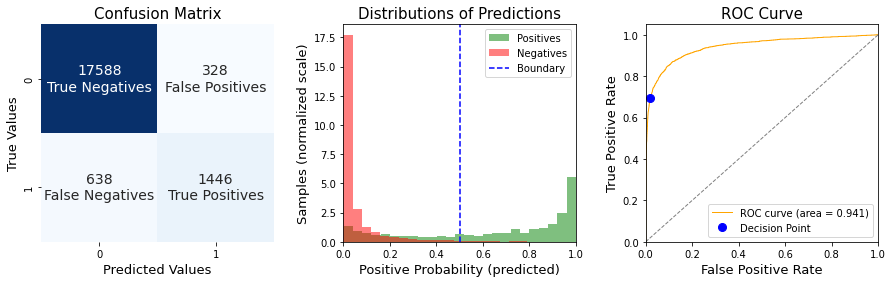

Precision: 0.815 | Recall: 0.694 | F1 Score: 0.75 | AUC: 0.941


In [7]:
### RFA CV performances ###

binary_performances(y, y_pred)

In [8]:
### CV Recursive Feature Elimination ###

y_pred = np.zeros((y.shape[0],2))

for i,(id_train,id_test) in enumerate(CV.split(X,y)):
    
    print(f"--- {i+1} fold ---")
    
    model = BoostRFE(
        lgbm, 
        step=3,
        param_grid=param_dist_hyperopt, 
        greater_is_better=True, 
        n_iter=30, sampling_seed=123
    )
    model.fit(
        X.iloc[id_train], y[id_train], 
        trials=Trials(), 
        eval_set=[(X.iloc[id_test], y[id_test])], 
        callbacks=[early_stopping(5, verbose=False)], eval_metric=F1
    )
    y_pred[id_test] = model.predict_proba(X.iloc[id_test])
    
    rfe_results[f"{i+1} fold"] = model.support_
    rfe_scores[f"{i+1} fold"] = model.best_score_
    print()

--- 1 fold ---

30 trials detected for ('class_weight', 'subsample', 'num_leaves', 'learning_rate', 'reg_alpha', 'reg_lambda', 'feature_fraction')

trial: 0001 ### iterations: 00021 ### eval_score: 0.56159
trial: 0002 ### iterations: 00021 ### eval_score: 0.56159
trial: 0003 ### iterations: 00078 ### eval_score: 0.73239
trial: 0004 ### iterations: 00078 ### eval_score: 0.73239
trial: 0005 ### iterations: 00078 ### eval_score: 0.73239
trial: 0006 ### iterations: 00078 ### eval_score: 0.73239
trial: 0007 ### iterations: 00078 ### eval_score: 0.73239
trial: 0008 ### iterations: 00078 ### eval_score: 0.73239
trial: 0009 ### iterations: 00078 ### eval_score: 0.73239
trial: 0010 ### iterations: 00078 ### eval_score: 0.73239
trial: 0011 ### iterations: 00041 ### eval_score: 0.77951
trial: 0012 ### iterations: 00041 ### eval_score: 0.77951
trial: 0013 ### iterations: 00041 ### eval_score: 0.77951
trial: 0014 ### iterations: 00041 ### eval_score: 0.77951
trial: 0015 ### iterations: 00041 ### ev

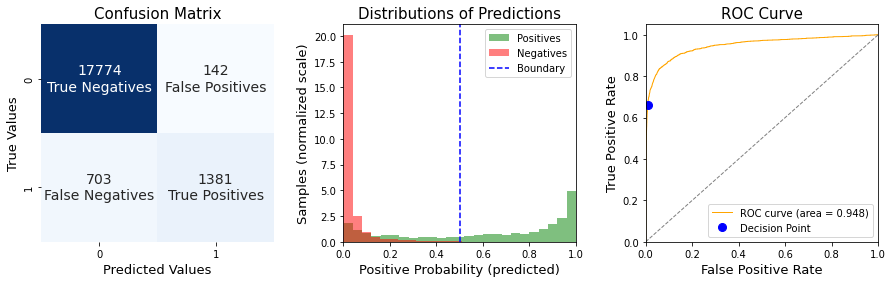

Precision: 0.907 | Recall: 0.663 | F1 Score: 0.766 | AUC: 0.948


In [9]:
### RFE CV performances ###

binary_performances(y, y_pred)

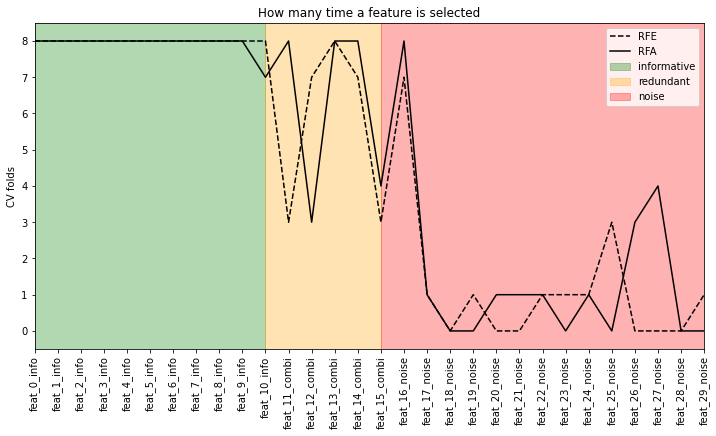

In [10]:
### SELECTED FEATURES ###

plt.figure(figsize=(12, 6))
plt.plot(
    range(n_feat), 
    np.sum(list(rfe_results.values()), axis=0), 
    label='RFE', c='black', linestyle='--'
)
plt.plot(
    range(n_feat), 
    np.sum(list(rfa_results.values()), axis=0), 
    label='RFA', c='black'
)
plt.xlim(0, n_feat-1)
plt.ylim(-0.5,len(rfe_results)+0.5)
plt.axvspan(informartive_feat[0], informartive_feat[-1], alpha=0.3, color='green', label='informative')
plt.axvspan(redundant_feat[0]-1, redundant_feat[-1], alpha=0.3, color='orange', label='redundant')
plt.axvspan(noise_feat[0]-1, noise_feat[-1], alpha=0.3, color='red', label='noise')
plt.xticks(range(n_feat), X.columns, rotation=90)
plt.title('How many time a feature is selected')
plt.ylabel('CV folds')
plt.legend(); plt.show()